I certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I did not receive any external help, coaching or contributions during the production of this work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import gym
from gym import spaces
from google.colab import widgets
import time
import random

/Users/rivendell/opt/anaconda3/envs/py36/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [2]:
class StoGridEnvironment(gym.Env):
    metadata = {'render.modes': []}
    
    def __init__(self, max_timesteps):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps
        
    def reset(self):
        self.timestep = 0        
        
        self.agent_pos = [0,0]       #origin of agent
        
        self.goal_pos = [3,3]        #position of the THE RING (the goal)
        
        self.gollum_pos = [1,3]      #position of gollum
        self.gollum =True
        
        self.rivendell_pos = [0,1]   #position of Rivendell, the house of elves
        self.rivendell =True
        self.aragorn_pos = [1,2]     #position of aragorn, the heir to the throne
        self.aragorn =True
        self.mordor_mountains_pos = [[2,1], [2,2]]    #position of Mordor mountains
        self.mordor1 =True
        self.mordor2 =True
        self.gandalf_pos = [3,2]     #position of gandalf
        self.gandalf =True
        self.moria_pos = [3,0]       #position of moria where the agent gets lost and comes out of anywhere
        self.moria =True
        
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        
        self.reward = 0             #resetting the reward to 0
        self.total_reward = 0
        return observation
    
    def step(self, action, observation):
        prev_obs = observation
        action = random.choices([action, 2], weights =(90,10),k=1)[0]
        if action == 0:
            self.agent_pos[0] += 1
        if action ==1 :
            self.agent_pos[0] -= 1
        if action ==2:
            self.agent_pos[1] += 1
        if action == 3:
            self.agent_pos[1] -= 1
            
        self.agent_pos = np.clip(self.agent_pos, 0 ,3)
        if (self.agent_pos == self.moria_pos).all():
            self.agent_pos[0] = np.random.randint(4)
            self.agent_pos[1] = np.random.randint(4)
        
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        self.reward = 0
        if (self.agent_pos == self.goal_pos).all():
            self.reward = 20
            self.total_reward += 20
            done = True
            info = "The Fellowship of the ring has destroyed the ring in the fire of mordor"
            return prev_obs, observation, self.reward, done, info
        
        elif (self.agent_pos == self.rivendell_pos).all() and self.rivendell:
            self.reward = 2
            self.total_reward += 2
            self.rivendell = False
            
        elif (self.agent_pos == self.aragorn_pos).all() and self.aragorn: 
            self.reward = 2
            self.total_reward += 2
            self.aragorn = False
            
        elif (self.agent_pos == self.gollum_pos).all() and self.gollum:
            self.reward = -2
            self.total_reward -=2
            self.gollum = False
        
        elif (self.agent_pos == self.mordor_mountains_pos[0]).all() and self.mordor1:
            self.reward = -4
            self.total_reward -=2
            self.mordor1 = False
            
        elif (self.agent_pos == self.mordor_mountains_pos[0]).all() and self.mordor2:
            self.reward = -4
            self.total_reward -=2
            self.mordor2 = False
            
        elif (self.agent_pos == self.gandalf_pos).all() and self.gandalf:
            self.reward = 4
            self.total_reward -=2
            self.gandalf = False
            
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps else False
        
        info = {}
        
        return prev_obs, observation, self.reward, done, info
    
    def render(self, mode='human', plot = False):
        """This method renders the environment."""
        
        fig, ax = plt.subplots(figsize=(10,10)) # initializating the array
        ax.set_xlim(0,4) #setting the limit on x-axis
        ax.set_ylim(0,4) #setting the limit on the y-axis)
        
        def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular position on the grid and renders the appropriate image"""
            
            #initially setting every objet to not be plotted
            plot_agent, plot_gollum, plot_rivendell, plot_aragorn, plot_mordor, plot_gandalf, plot_moria, plot_ring = \
            False, False, False, False, False, False, False, False
            
            #checking which objects need to be plotted by comparing their positions
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            
            if np.array_equal(plot_pos, self.gollum_pos):
                plot_gollum = True
            
            if np.array_equal(plot_pos, self.rivendell_pos):
                plot_rivendell = True
                
            if np.array_equal(plot_pos, self.aragorn_pos):
                plot_aragorn = True
                
            if any(np.array_equal(self.mordor_mountains_pos[i], plot_pos) for i in range(len(self.mordor_mountains_pos))):
                plot_mordor = True
                
            if np.array_equal(plot_pos, self.gandalf_pos):
                plot_gandalf = True
                
            if np.array_equal(plot_pos, self.moria_pos):
                plot_moria = True
                
            if np.array_equal(plot_pos, self.goal_pos):
                plot_ring = True
                        
            #plot for agent
            if plot_agent:
                agent = AnnotationBbox(OffsetImage(plt.imread('./images/agent.png'), zoom=0.35), np.add(plot_pos, [0.5, 0.5]), frameon = False)
                ax.add_artist(agent)
                    
                
            #plot for gollum
            elif plot_gollum and all(not item for item in [plot_agent, plot_rivendell, plot_aragorn, plot_mordor, plot_gandalf, plot_moria, plot_ring]):
                gollum = AnnotationBbox(OffsetImage(plt.imread('./images/gollum.png'), zoom=0.36),np.add(plot_pos, [0.5, 0.5]), frameon=False)
            
                ax.add_artist(gollum)
                    
            #plot for rivendell
            elif plot_rivendell and all(not item for item in [plot_agent, plot_gollum, plot_aragorn, plot_mordor, plot_gandalf, plot_moria, plot_ring]):
                rivendell = AnnotationBbox(OffsetImage(plt.imread('./images/rivendell.png'), zoom=0.18),np.add(plot_pos, [0.5, 0.5]), frameon=False)
            
                ax.add_artist(rivendell)
                    
            #plot for aragorn
            elif plot_aragorn and all(not item for item in [plot_agent, plot_gollum, plot_rivendell, plot_mordor, plot_gandalf, plot_moria, plot_ring]):
                aragorn = AnnotationBbox(OffsetImage(plt.imread('./images/aragorn.png'), zoom=0.35),np.add(plot_pos, [0.5, 0.5]), frameon=False)
            
                ax.add_artist(aragorn)
                
            #plot for mordor
            elif plot_mordor and all(not item for item in [plot_agent, plot_gollum, plot_rivendell, plot_aragorn, plot_gandalf, plot_moria, plot_ring]):
                mordor = AnnotationBbox(OffsetImage(plt.imread('./images/mordor.png'), zoom=1.1),np.add(plot_pos, [0.5, 0.5]), frameon=False)
            
                ax.add_artist(mordor) 
                
            #plot for gandalf
            elif plot_gandalf and all(not item for item in [plot_agent, plot_gollum, plot_rivendell, plot_aragorn, plot_mordor, plot_moria, plot_ring]):
                gandalf = AnnotationBbox(OffsetImage(plt.imread('./images/gandalf.png'), zoom=0.22),np.add(plot_pos, [0.5, 0.5]), frameon=False)
            
                ax.add_artist(gandalf)                
                    
            #plot for moria
            elif plot_moria and all(not item for item in [plot_agent, plot_gollum, plot_rivendell, plot_aragorn, plot_mordor, plot_gandalf, plot_ring]):
                moria = AnnotationBbox(OffsetImage(plt.imread('./images/moria.png'), zoom=0.16),np.add(plot_pos, [0.5, 0.5]), frameon=False)
            
                ax.add_artist(moria)
                
            #plot for ring
            elif plot_ring and all(not item for item in [plot_agent, plot_gollum, plot_rivendell, plot_aragorn, plot_mordor, plot_gandalf, plot_moria]):
                ring = AnnotationBbox(OffsetImage(plt.imread('./images/ring.png'), zoom=0.1),np.add(plot_pos, [0.5, 0.5]), frameon=False)
            
                ax.add_artist(ring) 
             
        self.environment_height = 4
        self.environment_width = 4
        #way to call method is iterate over th grid
        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray([j % self.environment_width, int(np.floor(j/self.environment_width))])
                    
        #rendering the images for all states
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])
                
        plt.xticks([0,1,2,3])    #specifying the ticks on the xaxis
        plt.yticks([0,1,2,3])    #specifying the tikcs on the y axis
                    
        plt.grid()  #setting the plot to be of the type grid

In [3]:
class RandomAgent:
    def __init__(self, env, alpha, gamma, episodes):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        #self.q_table = np.random.rand(self.observation_space.n,self.action_space.n)
        self.q_table = np.full((self.observation_space.n,self.action_space.n),0)
        self.sarsa_table = np.full((self.observation_space.n,self.action_space.n),0)
        self.reward_space = np.full(episodes, 0)
        self.step_space_q_learning = np.full(episodes, 0)
        self.step_space_sarsa = np.full(episodes, 0)
        
        
    def get_reward(self, reward, step, discount, episode):
        reward = (discount**(step))*reward
        self.reward_space[episode] += reward
        return reward
    
    def choose_action(self, epsilon, obs):
        state = np.argmax(obs)
        random_action = np.random.randint(self.action_space.n)
        greedy_action = np.argmax(self.q_table[state])
        return random.choices([random_action, greedy_action], weights =(epsilon,1-epsilon),k=1)[0]
    
    def choose_action_sarsa(self, epsilon, obs):
        state = np.argmax(obs)
        random_action = np.random.randint(self.action_space.n)
        greedy_action = np.argmax(self.sarsa_table[state])
        return random.choices([random_action, greedy_action], weights =(epsilon,1-epsilon),k=1)[0]
    
    
    def update_q_table(self,prev_obs,  obs, action, reward, alpha, gamma):
        prev_state = np.argmax(prev_obs)
        state = np.argmax(obs)
        curr_q = self.q_table[prev_state][action]
        self.q_table[prev_state][action] = curr_q + alpha*(reward + gamma*max(self.q_table[state]) - curr_q)
        return
    
    def update_sarsa_table(self,prev_obs,  obs, action, next_action, reward, alpha, gamma):
        prev_state = np.argmax(prev_obs)
        state = np.argmax(obs)
        curr_q = self.sarsa_table[prev_state][action]
        self.sarsa_table[prev_state][action] = curr_q + alpha*(reward + gamma*(self.sarsa_table[state][next_action]) - curr_q)
        return 

# Below cells have the train function for Q learning stochastic environment

In [4]:
def train(agent, steps, epsilon, obs, alpha, gamma,episode):
    history = np.zeros(steps)
    for step in range(steps):
        action = agent.choose_action(epsilon, obs)
        prev_obs, obs, instant_reward, done, info = env.step(action, obs)
        discounted_reward = agent.get_reward(instant_reward, step, gamma, episode)
        agent.update_q_table(prev_obs, obs, action, instant_reward, alpha, gamma)
        if step == 0: history[step] = discounted_reward
        else: history[step] = discounted_reward + history[step-1]
        if done: 
            history[step+1:].fill(history[step])
            agent.step_space_q_learning[episode] = step+1
            break
    return history
    
def decay(final_epsilon_value, initial_epsilon_value, number_of_episodes):
    return round((np.float(final_epsilon_value)/initial_epsilon_value)**(1/np.float(number_of_episodes)),5)

In [5]:
alpha =0.15
gamma = 0.95
episodes = 500
steps = 10

env = StoGridEnvironment(steps)
agent = RandomAgent(env, alpha, gamma, episodes)

obs = env.reset()
done = False

# output_grid = widgets.Grid(1,1)
# with output_grid.output_to(0,0):
#     env.render()

final_epsilon = 0.01
epsilon= initial_epsilon = 1
decaying_factor = decay(final_epsilon, initial_epsilon, episodes)
reward_per_episode = []
epsilon_per_episode = []
avg_outcome_eps0p0 = np.zeros(steps)
for episode in range(episodes):

    obs = env.reset()
    done =False

    avg_outcome_eps0p0 += train(agent, steps, epsilon, obs, alpha, gamma, episode)
    reward_per_episode.append(env.total_reward)
    epsilon_per_episode.append(epsilon)
    epsilon = max(decaying_factor*epsilon, final_epsilon)
#Below code was used for checkpoint 1 and will slow down the iterations
#     while not done:
#         action = agent.step(obs)
#         obs, reward, done, info = env.step(action)
#         with output_grid.output_to(0,0):
#             output_grid.clear_cell()
#             env.render()
#         print("reward", reward)
#         time.sleep(1)
        
avg_outcome_eps0p0 /= np.float(episodes)

No handles with labels found to put in legend.


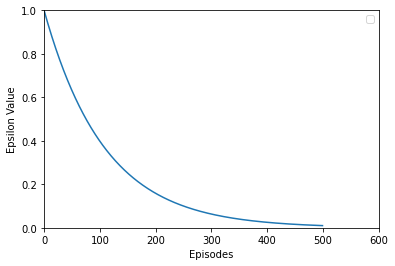

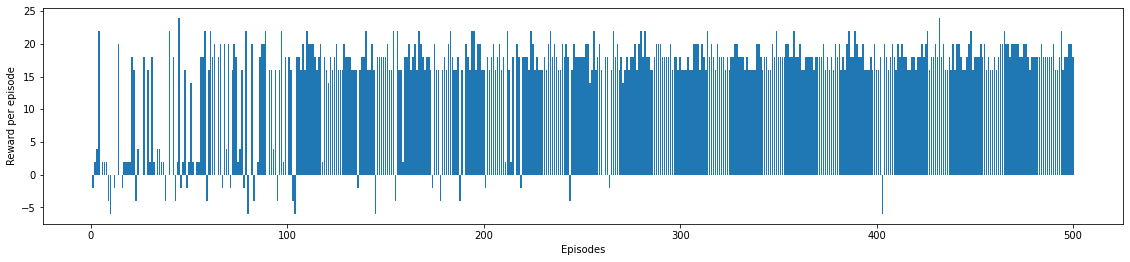

In [6]:
# print(avg_outcome_eps0p0)
# plt.plot(avg_outcome_eps0p0,label="eps = 0.0")
# # plt.plot(avg_outcome_eps0p01,label="eps = 0.01")
# # plt.plot(avg_outcome_eps0p1,label="eps = 0.1")
# plt.ylim(0,100)
# plt.xlim(0,100)
# plt.legend()
# plt.show()

plt.plot(epsilon_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Epsilon Value")
plt.ylim(0,1)
plt.xlim(0,600)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,3))
ax = fig.add_axes([100,100,1,1])
plt.xlabel("Episodes")
plt.ylabel("Reward per episode")
langs = range(1,len(reward_per_episode)+1)
students = reward_per_episode
ax.bar(langs,students)
plt.show()

# Below cells use the same env and agent class but have a new training function as sarsa and Q learning are trained differently

In [7]:
def train_sarsa(agent, steps, epsilon, obs, alpha, gamma,episode, curr_action):
    history_sarsa = np.zeros(steps)
    action = curr_action
    for step in range(steps):
        prev_obs, obs, instant_reward, done, info = env.step(action, obs)
        action_next = agent.choose_action_sarsa(epsilon, obs)
        discounted_reward = agent.get_reward(instant_reward, step, gamma, episode)
        agent.update_sarsa_table(prev_obs, obs, action, action_next, instant_reward, alpha, gamma)
        action = action_next
        if step == 0: history_sarsa[step] = discounted_reward
        else: history_sarsa[step] = discounted_reward + history_sarsa[step-1]
        if done: 
            history_sarsa[step+1:].fill(history_sarsa[step])
            agent.step_space_sarsa[episode] = step+1
            break
    return history_sarsa
    

In [9]:
alpha =0.15
gamma = 0.95
episodes = 500
steps = 10

env = StoGridEnvironment(steps)
agent = RandomAgent(env, alpha, gamma, episodes)

obs = env.reset()
done = False

# output_grid = widgets.Grid(1,1)
# with output_grid.output_to(0,0):
#     env.render()

final_epsilon = 0.01
epsilon= initial_epsilon = 1
decaying_factor = decay(final_epsilon, initial_epsilon, episodes)

reward_per_episode_sarsa = []
epsilon_per_episode_sarsa = []
avg_outcome_eps0p0_sarsa = np.zeros(steps)
for episode in range(episodes):

    obs = env.reset()
    done =False
    action = agent.choose_action_sarsa(epsilon, obs)
    avg_outcome_eps0p0_sarsa += train_sarsa(agent, steps, epsilon, obs, alpha, gamma, episode, action)
    reward_per_episode_sarsa.append(env.total_reward)
    epsilon_per_episode_sarsa.append(epsilon)
    epsilon = max(decaying_factor*epsilon, final_epsilon)
#     while not done:
#         action = agent.step(obs)
#         obs, reward, done, info = env.step(action)
#         with output_grid.output_to(0,0):
#             output_grid.clear_cell()
#             env.render()
#         print("reward", reward)
#         time.sleep(1)
        
avg_outcome_eps0p0_sarsa /= np.float(episodes)
#print(reward_per_episode_sarsa)

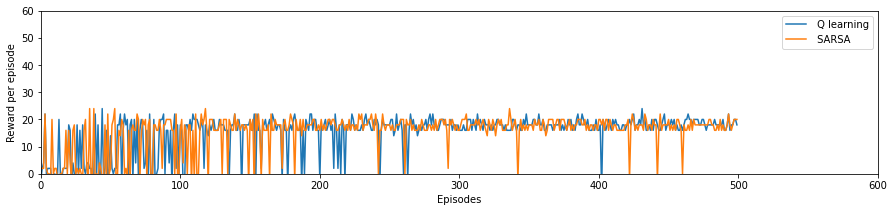

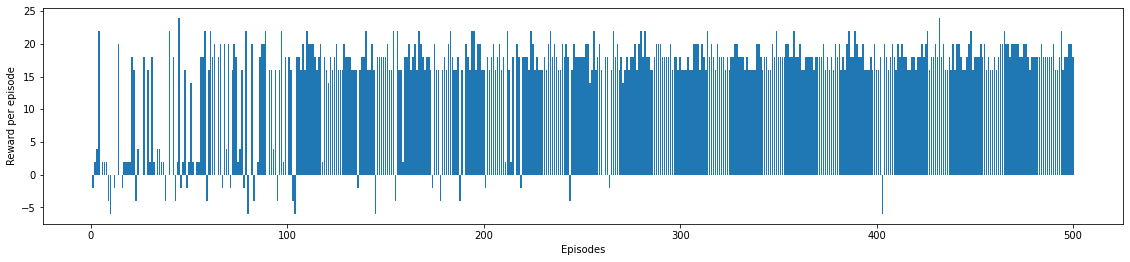

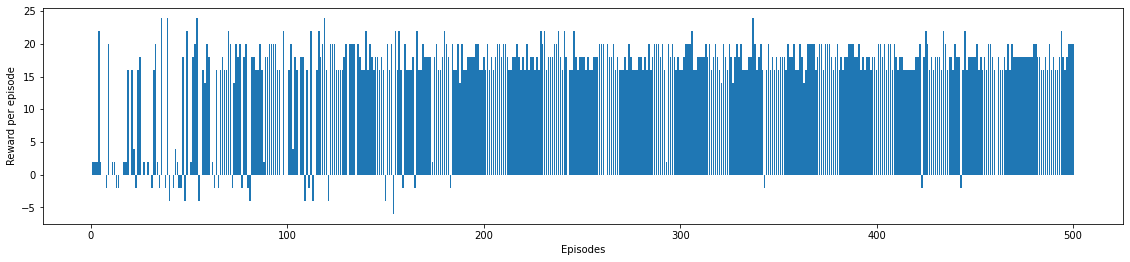

In [10]:
fig = plt.figure(figsize=(15,3))
plt.plot(reward_per_episode,label=" Q learning")
plt.plot(reward_per_episode_sarsa,label=" SARSA")
plt.ylim(0,60)
plt.xlim(0,600)
plt.xlabel("Episodes")
plt.ylabel("Reward per episode")
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,3))
ax = fig.add_axes([100,100,1,1])
langs = range(1,len(reward_per_episode)+1)
y_axis = reward_per_episode
plt.xlabel("Episodes")
plt.ylabel("Reward per episode")
ax.bar(langs,y_axis)
plt.show()

fig = plt.figure(figsize=(15,3))
ax = fig.add_axes([100,100,1,1])
langs = range(1,len(reward_per_episode_sarsa)+1)
y_axis = reward_per_episode_sarsa
plt.xlabel("Episodes")
plt.ylabel("Reward per episode")
ax.bar(langs,y_axis)
plt.show()